### Mount Drive and make imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle
import numpy as np
import cv2
import pylab as plt
import os
import time

### Declare needed constants

In [0]:
path = "/content/drive/My Drive/Course_work_SLR/lsa64_raw_dataset/all"
load_path = '/content/drive/My Drive/Course_work_SLR/lsa64_raw_dataset'
load_path_hands = '/content/drive/My Drive/Course_work_SLR/lsa64_raw_dataset/hands_masked'
video_name = '{sign_num}_{human_num}_00{attempt_num}.mp4'
print(path)

FRAME_COUNT = 10  # number of frames, extracted from video
SIGN_COUNT = 10  # total count of signs that will be parsed (max=64)
FRAME_SIZE = (380, 212)  # resulting frame size after reshaping

log = 1  # log mode
BLUE = 60  # hue value for blue color
PINK = 160  # hue value for pink color

/content/drive/My Drive/Course_work_SLR/lsa64_raw_dataset/all


### Function for dumping data

In [0]:
# need to copy Data.py file from Drive to use locally
!cp "/content/drive/My Drive/Course_work_SLR/src/Data.py" .

In [0]:
from Data import Data

def dump_to_file(x_train, x_test, y_train, y_test, file_name, load_path=load_path):
    res = Data(x_train, x_test, y_train, y_test)
    with open(os.path.join(load_path, file_name), 'wb') as fout:
        pickle.dump(res, fout)


### Functions for frames proccesing

In [0]:
def apply_mask(frame, color, gap=10, lower_s=50, lower_v=50, upper_s=255, upper_v=255):
    """
    :param: color - must be an integer representing H-value of color in HSV format
    :return: resulting mask
    """
    # add some gap
    lower_bound = np.array([color - gap, lower_s, lower_v])
    upper_bound = np.array([color + gap, upper_s, upper_v])
    
    # first num є [0, 180]
    if (lower_bound[0] < 0): 
        lower_bound[0] = 0
    if (upper_bound[0] > 180):
        upper_bound[0] = 180
    return cv2.inRange(frame, lower_bound, upper_bound)

def parse_frame(frame, colors):
    """
    :param frame: original frame
    :param colors: iterable of integers represinting H value of the color
    :return: parsed frame
    """
    resized = cv2.resize(frame, FRAME_SIZE)  # resize frame

    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)  # from RGB to HSV
    
    masks = []
    for h in colors:
        masks.append(apply_mask(hsv, h))
    
    mask = sum(masks)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((3,3),np.uint8))

    # Segmenting the cloth out of the frame using bitwise_and with the inverted mask
    masked = cv2.bitwise_and(hsv, hsv, mask=mask)
    h, s, masked_grey = cv2.split(masked)
    return masked_grey

### Parse SIGN_COUNT signs from dataset

In [0]:
x_train = []
x_test = []
y_train = []
y_test = []

start = time.time()

for sign in range(1, SIGN_COUNT + 1):
    if log > 0: 
        print(f'Sign {sign}')
    for human in range(1, 11):
        if log > 1:
            print(f'Sign {sign} human {human}')
        for attempt in range(1, 6):
            cur = os.path.join(path,
                                video_name.format(sign_num=str(sign).rjust(3, "0"),
                                                    human_num=str(human).rjust(3, "0"),
                                                    attempt_num=attempt))
            cap = cv2.VideoCapture(cur)
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # total number of frames
            frame_step = int(length / FRAME_COUNT)  # every frame_step's frame is taken
            
            frame_num = 0  # current frame num
            cur_sign = []
            
            while cap.isOpened():
                frame_num += 1
                if not cap.grab():
                    break
                if frame_num % frame_step != 0:
                    continue
                ret, frame = cap.retrieve()
                
                masked_grey = parse_frame(frame, (BLUE, PINK))

                cur_sign.append(masked_grey)
                
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
            if attempt == 5:  # every 5-th attempt - test
                x_test.append(np.array(cur_sign[:FRAME_COUNT]))
                y_test.append(sign - 1)
            else:
                x_train.append(np.array(cur_sign[:FRAME_COUNT]))
                y_train.append(sign - 1)

if log > 0:
    delta = time.time() - start
    print(f'{delta//60} m {int(delta%60)} s elapsed...')

Sign 1
Sign 2
Sign 3
Sign 4
Sign 5
Sign 6
Sign 7
Sign 8
Sign 9
Sign 10
4.0 m 48 s elapsed...


In [0]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
# # if need only to visualize already parsed data
# # import Data class from My drive
# !cp "/content/drive/My Drive/Course_work_SLR/src/Data.py" .
# from Data import Data
# with open('/content/drive/My Drive/Course_work_SLR/lsa64_raw_dataset/hands_masked/masked_data_64.pkl', 'rb') as file:
#     data = pickle.load(file)
# x_train, x_test, y_train, y_test = data.x_train, data.x_test, data.y_train, data.y_test

In [0]:
x_train.shape

(400, 10, 212, 380)

### Visualize examples for each sign (1 image per sign)

In [0]:
test_data = []
t = 0
r = 0
for i in range(8):
    test_data.append([])
    for j in range(8):
        test_data[r].append(x_train[40*t][0])
        t += 1
    r += 1

test_data = np.array(test_data)

In [0]:
test_data.shape

(8, 8, 212, 380)

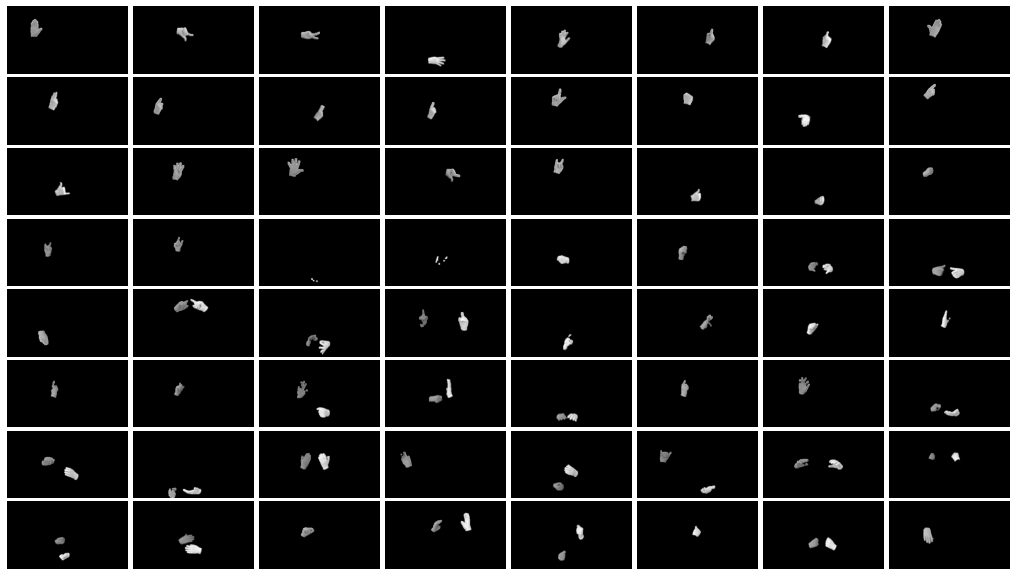

In [0]:
heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 14.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(8, 8, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(8):
    for j in range(8):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0.05, left=0, right=1, bottom=0, top=1)
plt.show()

### Dump parsed data to corresponding file

In [0]:
dump_to_file(x_train, x_test, y_train, y_test, file_name=f'masked_data_{SIGN_COUNT}.pkl', load_path=load_path_hands)